In [1]:
import pandas as pd
import numpy as np
import time
import torchvision
from torchvision import models
import torch.nn as nn
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split, StratifiedKFold
from PIL import Image, ImageFile
from torch.utils.data import Dataset
import torch
import torch.optim as optim
from torchvision import transforms
from torch.optim import lr_scheduler
import os
import random
import cv2
import copy
import matplotlib.pyplot as plt
%matplotlib inline
from skimage import io, transform
from efficientnet_pytorch import EfficientNet

from apex import amp
from os.path import isfile
import warnings
warnings.filterwarnings("ignore")

print(os.listdir("input"))

['testLabels15.csv', 'test.csv', 'resized', 'resized_256', 'sample_submission.csv', 'train_new.csv', 'trainLabels_new.csv', 'trainLabels19.csv', 'train_df.pkl', '.ipynb_checkpoints', 'testImages19.csv', 'train.csv', 'labels.zip', 'trainLabels15.csv', 'test_images', 'trainLabels.csv', 'train_images']


In [2]:
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, RandomBrightnessContrast, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, Flip, OneOf, Compose, Resize, Normalize
)
from albumentations.pytorch import ToTensor

## Define class and functions

In [3]:
def scaleRadius(img,scale):
    add = int(img.shape[0]/2)
    x=img[add,:,:].sum(1)
    r=(x>x.mean()/10).sum()/2
    s=scale*1.0/r
    return cv2.resize(img,(0,0),fx=s,fy=s)

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

def imshow(inp, title=None):
    """Imshow for Tensor."""
    plt.figure(figsize=(12,12))
    inp = inp.numpy().transpose((1, 2, 0))
    #undo normalising
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp,0,1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
        
def expand_path(p):
    p = str(p)
    if isfile(train_og + p + ".png"):
        return train_og + (p + ".png")
    if isfile(test_og + p + ".png"):
        return test_og + (p + ".png")    
    elif isfile(train + p + ".jpg"):
        return train + (p + ".jpg")
#     elif isfile(test + p + ".png"):
#         return test + (p + ".png")
#     if isfile(train + p + ".png"):
#         return train + (p + ".png")
#     if isfile(train_2015 + p + '.jpeg'):
#         return train_2015 + (p + ".jpeg")
#     if isfile(test + p + ".png"):
#         return test + (p + ".png")
    return p  

def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img
    
def circle_crop_v2(img):
    """
    Create circular crop around image centre
    """
    height, width, depth = img.shape
    largest_side = np.max((height, width))
    img = cv2.resize(img, (largest_side, largest_side))

    height, width, depth = img.shape

    x = int(width / 2)
    y = int(height / 2)
    r = np.amin((x, y))

    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x, y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)

    return img


class MyEyeDataset(Dataset):

    def __init__(self, dataframe, training=True, transform=None, sigmax=10):
        self.df = dataframe
        self.transform = transform
        self.training = training
        self.sigmax = sigmax
    
    def __len__(self):
        return len(self.df)
   
    def __getitem__(self, idx):
        
        img_name = self.df.id_code.values[idx]
        img_name = expand_path(img_name) 
        image = cv2.imread(img_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = crop_image_from_gray(image)
        
        #image = cv2.addWeighted (image,4, cv2.GaussianBlur( image , (0,0) , self.sigmax) ,-4 ,128)
        

        
        image = transforms.ToPILImage()(image)  
        
        p = np.random.uniform(0,1)
        if self.training == True:
            zoom_factor = np.random.uniform(1.1,1.3,1)[0]
            zoom_factor = 1/zoom_factor
            w, h = image.size 
            crop_h = h*zoom_factor
            crop_w = w*zoom_factor
            image = transforms.functional.center_crop(image, (crop_h, crop_w))
            
        #image = transforms.functional.adjust_contrast(image, 1.3)
        
        if self.transform:
            image = self.transform(image)

            
        label = torch.tensor(self.df.loc[idx, 'diagnosis'])
        
        return image, label

def train_model(epoch):
    model.train() 
        
    avg_loss = 0.
    optimizer.zero_grad()
    for idx, (imgs, labels) in enumerate(train_loader):
        labels = labels.view(-1, 1) 
        imgs_train, labels_train = imgs.cuda(), labels.float().cuda()
        output_train = model(imgs_train)
        loss = criterion(output_train,labels_train)
#         with amp.scale_loss(loss, optimizer) as scaled_loss:
#             scaled_loss.backward()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad() 
        avg_loss += loss.item() / len(train_loader)
        
    return avg_loss

def test_model():
    
    avg_val_loss = 0.
    model.eval()
    with torch.no_grad():
        for idx, (imgs, labels) in enumerate(val_loader):
            labels = labels.view(-1, 1) 
            imgs_vaild, labels_vaild = imgs.cuda(), labels.float().cuda()
            output_test = model(imgs_vaild)
            avg_val_loss += criterion(output_test, labels_vaild).item() / len(val_loader)
        
    return avg_val_loss

## Constants

In [4]:
input_dir = 'input'

num_classes = 1
seed_everything(9081)
lr          = 1e-3/2
IMG_SIZE    = 256
BS = 16
n_epochs      = 20

sigmax = 15

model_name = "model/50_b4_old_pretrain.bin"
model_name_new_data = "model/50_b4_new_data"
enet= 'efficientnet-b4'



In [5]:
#train      = 'input/train_images/'
train      = 'input/resized/'
train_og = 'input/train_images/'
test_og  = 'input/test_images/'
train_2015 = 'input/resized_train/'


train_csv  = pd.read_csv('input/trainLabels19.csv')
train_csv_old  = pd.read_csv('input/trainLabels15.csv')
test_csv_old = pd.read_csv('input/testLabels15.csv')
test_csv_old.drop(['Usage'], axis=1, inplace=True)
train_csv_old = train_csv_old.append(test_csv_old, ignore_index=True)
train_csv_old.columns = train_csv.columns

sample = pd.read_csv('input/sample_submission.csv')


#train_df, val_df = train_test_split(train_csv, test_size=0.15, random_state=98)
train_df = train_csv_old
val_df = train_csv
train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)

#original_dist = train_csv.groupby('diagnosis')['id_code'].count().reset_index()

In [6]:
train_df.groupby('diagnosis')['id_code'].count()/train_df.shape[0]

diagnosis
0    0.736658
1    0.069953
2    0.148283
3    0.023528
4    0.021578
Name: id_code, dtype: float64

In [7]:
train_df.groupby('diagnosis')['id_code'].count()

diagnosis
0    65343
1     6205
2    13153
3     2087
4     1914
Name: id_code, dtype: int64

In [8]:
pl_dist = {       0  :  0.146266,
        1  :  0.122925,
        2  :  0.576763,
        3  :  0.135892,
        4  :  0.018154}


pl_dist = {0: 4554, 1: 3505, 2: 13153, 3: 2087, 4: 1914}

In [9]:
# sample_map = train_csv_old.groupby('diagnosis')['id_code'].count().reset_index()

# sample_map = sample_map['id_code'].to_dict()
# sample_map

In [10]:
  
def make_balance_df (new_df, old_df):
    
    sample_map[0] = 10000
    
    for n in range(5):
        class_df = old_df.query(f'diagnosis=={n}')
        n_sample = sample_map[n]
        up_sample_df = class_df.sample(n=n_sample)
        new_df = new_df.append(up_sample_df,ignore_index=True)
        
    return new_df

  
def make_balance_df_old (old_df):
       
    for n in range(5):
        class_df = old_df.query(f'diagnosis=={n}')
        n_sample = pl_dist[n]
        up_sample_df = class_df.sample(n=n_sample,random_state=8)
        if n == 0:
            new_df = up_sample_df.copy()
        else:    
            new_df = new_df.append(up_sample_df,ignore_index=True)
        
    return new_df

In [11]:
train_df = make_balance_df_old(train_df)


In [12]:
train_df.groupby('diagnosis')['id_code'].count()

diagnosis
0     4554
1     3505
2    13153
3     2087
4     1914
Name: id_code, dtype: int64

In [13]:
train_df.groupby('diagnosis')['id_code'].count()/train_df.shape[0]

diagnosis
0    0.180621
1    0.139016
2    0.521675
3    0.082775
4    0.075913
Name: id_code, dtype: float64

In [14]:
train_df.shape

(25213, 2)

In [15]:
trn_tsfm = transforms.Compose([ 
    
    transforms.RandomResizedCrop((IMG_SIZE,IMG_SIZE), scale=(0.5, 0.9), ratio=(0.75, 1.3333333333333333)),
                           #transforms.Resize((IMG_SIZE,IMG_SIZE), interpolation=2),
                           #transforms.Resize((IMG_SIZE,IMG_SIZE), interpolation=2),
                           transforms.RandomHorizontalFlip(),
                           transforms.RandomVerticalFlip(),
                           transforms.RandomRotation(360),
                           transforms.ColorJitter(brightness=(1,1.6),contrast=(0.75,2.2)),
                           transforms.ToTensor(),
                           transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                                              ])


test_tsfm = transforms.Compose([
                           transforms.Resize((IMG_SIZE,IMG_SIZE), interpolation=2),
                           transforms.ToTensor(),
                           transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                                              ])

train_set = MyEyeDataset(train_df, transform = trn_tsfm, training=False, sigmax=sigmax)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BS, shuffle=True, num_workers=4)

val_set       = MyEyeDataset(val_df, transform = test_tsfm, training=True, sigmax=sigmax)
val_loader   = torch.utils.data.DataLoader(val_set, batch_size=BS, shuffle=False, num_workers=4)

test_set       = MyEyeDataset(sample, transform = test_tsfm, training=False, sigmax=sigmax)
test_loader   = torch.utils.data.DataLoader(test_set, batch_size=BS, shuffle=False, num_workers=4)


## Visualise a few images

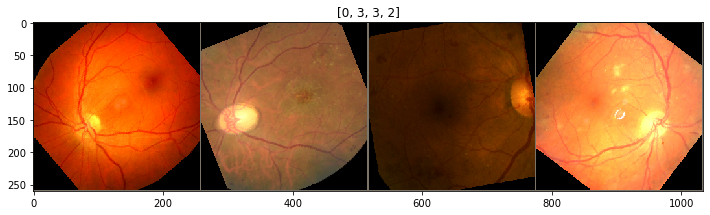

In [16]:

example_loader = torch.utils.data.DataLoader(train_set, batch_size=4, shuffle=True, num_workers=4)

class_names = [0,1,2,3,4]
# Get a batch of training data
inputs, classes = next(iter(example_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

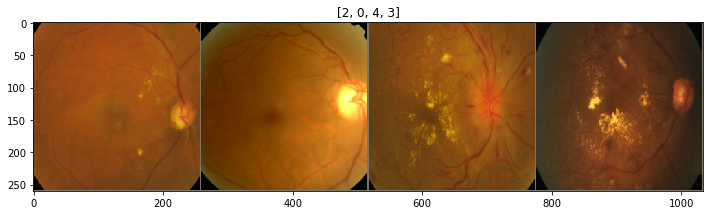

In [17]:

example_loader = torch.utils.data.DataLoader(val_set, batch_size=4, shuffle=True, num_workers=4)

class_names = [0,1,2,3,4]
# Get a batch of training data
inputs, classes = next(iter(example_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

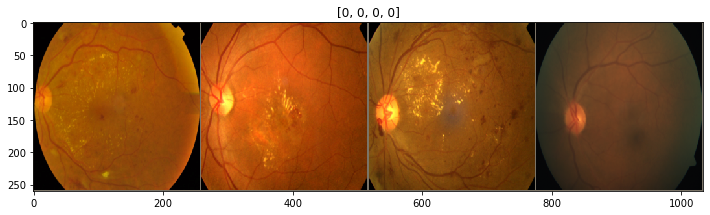

In [18]:
example_loader = torch.utils.data.DataLoader(test_set, batch_size=4, shuffle=True, num_workers=4)

class_names = [0,1,2,3,4]
# Get a batch of training data
inputs, classes = next(iter(example_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [19]:
device = torch.device("cuda:0")
torch.cuda.is_available()


True

### Define Model

In [20]:
device = torch.device("cuda:0")
torch.cuda.is_available()


model =  EfficientNet.from_pretrained(enet) 
in_features = model._fc.in_features
for param in model.parameters():
    param.requires_grad = False
    
model._fc = nn.Linear(in_features, num_classes)


    
model.cuda()


Loaded pretrained weights for efficientnet-b4


EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        48, 12, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        12, 48, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        48, 24, kernel_siz

In [21]:
# for param in model.parameters():
#     print(param.requires_grad)

In [22]:
torch.__version__

'1.1.0'

### Loss function and optimizor

In [23]:
criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
#model, optimizer = amp.initialize(model, optimizer, opt_level="O1",verbosity=0)


### 5 epochs last layer training

In [ ]:
best_avg_loss = 100.0

n_epochs = 5
for epoch in range(n_epochs):
    
    print('lr:', scheduler.get_lr()[0])
    start_time   = time.time()
    avg_loss     = train_model(epoch)
    avg_val_loss = test_model()
    elapsed_time = time.time() - start_time 
    print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f} \t time={:.2f}s'.format(
        epoch + 1, n_epochs, avg_loss, avg_val_loss, elapsed_time))
    
    if avg_val_loss < best_avg_loss:
        best_avg_loss = avg_val_loss
        torch.save(model.state_dict(), model_name)
    
    #scheduler.step()

lr: 0.0005
Epoch 1/5 	 loss=1.4105 	 val_loss=1.3173 	 time=305.08s
lr: 0.0005
Epoch 2/5 	 loss=1.1433 	 val_loss=1.3452 	 time=304.89s
lr: 0.0005


In [ ]:
#del model

torch.cuda.empty_cache() 

### Unfreeze all layers

In [ ]:
model =  EfficientNet.from_pretrained(enet) 
in_features = model._fc.in_features
model._fc = nn.Linear(in_features, num_classes)
#model.load_state_dict(torch.load(model_name))
model.cuda()

   
criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
#model, optimizer = amp.initialize(model, optimizer, opt_level="O1",verbosity=0)

In [ ]:
best_avg_loss = 100.0

n_epochs = 15

for epoch in range(n_epochs):
    
    print('lr:', scheduler.get_lr()[0])
    start_time   = time.time()
    avg_loss     = train_model(epoch)
    avg_val_loss = test_model()
    elapsed_time = time.time() - start_time 
    print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f} \t time={:.2f}s'.format(
        epoch + 1, n_epochs, avg_loss, avg_val_loss, elapsed_time))
    
    if avg_val_loss < best_avg_loss:
        best_avg_loss = avg_val_loss
        torch.save(model.state_dict(), model_name)
    
    scheduler.step()
    
del model

torch.cuda.empty_cache() 

## Train with 2019 data

In [ ]:
train_csv  = pd.read_csv('input/trainLabels19.csv')
sample = pd.read_csv('input/sample_submission.csv')


# train_df, val_df = train_test_split(train_csv, test_size=0.15, random_state=98)
# train_df.reset_index(drop=True, inplace=True)
# val_df.reset_index(drop=True, inplace=True)

#original_dist = train_csv.groupby('diagnosis')['id_code'].count().reset_index()



In [ ]:
#train_csv = train_csv.sample(500).reset_index()

### CV

In [ ]:
# model_name = "model/31_b3_old_pretrain.bin"
# model_name_new_data = "model/31_b3_new_data.bin"
device = torch.device("cuda:0")
torch.cuda.is_available()

torch.cuda.empty_cache() 

In [ ]:
from sklearn import metrics


clfs = []
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=54873)
oof_preds = np.zeros((len(train_csv), 1))
test_preds = np.zeros((len(train_csv), 1))


X = train_csv['id_code']
y = train_csv['diagnosis']
for fold_, (trn_, val_) in enumerate(folds.split(X, y)):
    print("Current Fold: {}".format(fold_+1))

    k_train_df = train_csv.iloc[trn_, :].reset_index()
    k_val_df = train_csv.iloc[val_, :].reset_index()
     
    train_set = MyEyeDataset(k_train_df, transform = trn_tsfm, training=False, sigmax=sigmax)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=BS, shuffle=True, num_workers=4)

    val_set       = MyEyeDataset(k_val_df, transform = test_tsfm, training=True, sigmax=sigmax)
    val_loader   = torch.utils.data.DataLoader(val_set, batch_size=BS, shuffle=False, num_workers=4)
    


    model =  EfficientNet.from_pretrained(enet) 
    in_features = model._fc.in_features
    model._fc = nn.Linear(in_features, num_classes)
    model.load_state_dict(torch.load(model_name))
    model.cuda()
    
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
    #model, optimizer = amp.initialize(model, optimizer, opt_level="O1",verbosity=0)
    
    
    best_avg_loss = 100.0

    n_epochs = 7
    fold_model_name = model_name_new_data + f'_fold_{fold_+1}.bin' 
    
    
    for epoch in range(n_epochs):

        print('lr:', scheduler.get_lr()[0])
        start_time   = time.time()
        avg_loss     = train_model(epoch)
        avg_val_loss = test_model()
        elapsed_time = time.time() - start_time 
        print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f} \t time={:.2f}s'.format(
            epoch + 1, n_epochs, avg_loss, avg_val_loss, elapsed_time))

        if avg_val_loss < best_avg_loss:
            best_avg_loss = avg_val_loss
            torch.save(model.state_dict(), fold_model_name)

        scheduler.step()
    
    
    
    
    model = EfficientNet.from_name(enet)
    in_features = model._fc.in_features
    model._fc = nn.Linear(in_features, num_classes)
    model.load_state_dict(torch.load(fold_model_name))
    model.cuda()

    for param in model.parameters():
        param.requires_grad = False

    model.eval()

    
    val_pred = np.zeros((len(k_val_df), 1))

    for i, data in tqdm(enumerate(val_loader)):
        images, labels = data
        images = images.to(device, dtype=torch.float)
        outputs = model(images) 
        val_pred[i * BS:(i + 1) * BS] += outputs.detach().cpu().squeeze().numpy().reshape(-1, 1)
    
    

    oof_preds[val_, :] = val_pred.reshape((-1, 1))
    




In [ ]:
oof_preds.shape

In [ ]:
coef = [0.5, 1.5, 2.5, 3.5]

for i, pred in enumerate(oof_preds):
    if pred < coef[0]:
        oof_preds[i] = 0
    elif pred >= coef[0] and pred < coef[1]:
        oof_preds[i] = 1
    elif pred >= coef[1] and pred < coef[2]:
        oof_preds[i] = 2
    elif pred >= coef[2] and pred < coef[3]:
        oof_preds[i] = 3
    else:
        oof_preds[i] = 4
        
train_csv['pred'] = oof_preds

metrics.cohen_kappa_score(train_csv['diagnosis'], train_csv['pred'], weights='quadratic')

In [ ]:
pd.pivot_table(train_csv,columns='pred',values='id_code',index='diagnosis',aggfunc='count').fillna(0)

In [ ]:
# import numpy as np
# import pandas as pd
# import os
# import scipy as sp
# from functools import partial
# from sklearn import metrics
# from collections import Counter
# import json



# class OptimizedRounder(object):
#     def __init__(self):
#         self.coef_ = 0

#     def _kappa_loss(self, coef, X, y):
#         X_p = np.copy(X)
#         for i, pred in enumerate(X_p):
#             if pred < coef[0]:
#                 X_p[i] = 0
#             elif pred >= coef[0] and pred < coef[1]:
#                 X_p[i] = 1
#             elif pred >= coef[1] and pred < coef[2]:
#                 X_p[i] = 2
#             elif pred >= coef[2] and pred < coef[3]:
#                 X_p[i] = 3
#             else:
#                 X_p[i] = 4

#         ll = metrics.cohen_kappa_score(y, X_p, weights='quadratic')
#         return -ll

#     def fit(self, X, y):
#         loss_partial = partial(self._kappa_loss, X=X, y=y)
#         initial_coef = [0.5, 1.5, 2.5, 3.5]
#         self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')

#     def predict(self, X, coef):
#         X_p = np.copy(X)
#         for i, pred in enumerate(X_p):
#             if pred < coef[0]:
#                 X_p[i] = 0
#             elif pred >= coef[0] and pred < coef[1]:
#                 X_p[i] = 1
#             elif pred >= coef[1] and pred < coef[2]:
#                 X_p[i] = 2
#             elif pred >= coef[2] and pred < coef[3]:
#                 X_p[i] = 3
#             else:
#                 X_p[i] = 4
#         return X_p

#     def coefficients(self):
#         return self.coef_['x']
    
# train_csv['pred'] = oof_preds
# optR = OptimizedRounder()
# optR.fit(train_csv['pred'], train_csv['diagnosis'])
# coefficients = optR.coefficients()
# train_csv['pred'] = optR.predict(train_csv['pred'], coefficients)



In [ ]:

# metrics.cohen_kappa_score(train_csv['diagnosis'], valid_predictions, weights='quadratic')

In [ ]:
# coefficients

In [ ]:
# pd.pivot_table(train_csv,columns='pred',values='id_code',index='diagnosis',aggfunc='count').fillna(0)